## Annexe, fig. 11 : MNIST dataset, TINY vs Big 

In [1]:
import sys
sys.path.append('../../TINY/')
import TINY 
import UTILS
from mes_imports import *
import load_data_Loader
import SOLVE_EB as EB

In [2]:
torch.set_num_threads(1)

In [3]:
def Loss_entropy(x1, x2, reduction = 'mean') :
    #print(x1.shape, x2.shape)
    return(torch.nn.CrossEntropyLoss(reduction = reduction)(x1, x2))



In [4]:
dico_performance = {'TINY' : {}, 'Random' : {}}
tot_nbr_pass = 5
init_deplacement = 1e-4
accroissement_decay = 1e-4
lr = 1e-3
epoch_sup = 4
epoch_btt = 0.1
starting_batch_size = 32

In [5]:
def stabilize_training() :
    MLP_model.batch_size = math.ceil(np.sqrt(MLP_model.count_parameters() / nbr_parameters_avant) *  MLP_model.batch_size)
    #MLP_model.batch_size = math.ceil(MLP_model.count_parameters() / nbr_parameters_avant *  MLP_model.batch_size)

In [6]:
dico_tracker = {'TINY' : {}, 'Big' : {}}

### TINY

In [7]:
strucs = []

In [8]:
for expe in range(5) :
    L_tr, L_te, A_tr, A_te, T = np.array([]), np.array([]), np.array([]), np.array([]), np.array([0])
    layer_name = {1 : 'L', 2 : 'L', 3 :'L'}
    skeleton = {0: {}, 1 : {'size' : 1}, 2 : {'size' : 1}, 3 : {'size' : 10}}
    fct = {depth : torch.nn.SELU() for depth in range(1, 3)}
    fct.update({3 : torch.nn.Identity()})
    dico_parameters = {
                     'skeleton' : copy.deepcopy(skeleton),
                    'Loss' : Loss_entropy,
                    'fct' : fct,
                    'layer_name' :layer_name,
                    'rescale' : 'DE',
                    'init_deplacement' : init_deplacement, # min amplitude factor
                    'batch_size' : starting_batch_size,# batchsize for training
                    'lr' : lr,# leraning rate for training
                    'lambda_method' : 0, # = 0 for searching the amplitude factor, if > 0 the 
                                         # amplitude factor is automatically set to this value
                    'accroissement_decay' : accroissement_decay,# the minimum decay to update the 
                                                 # architecture with the NewNeurons/BestUpdate 
                    'depth_seuil' : {1 : 10, 2 : 10}, #maximum number of neurons to add by depth
                    'lu_lin' : 5, #reduce the variance of estimators by sqrt of lu_lin > 1
                    'max_batch_estimation' : 100, # maximum size of batch at a time
                    'max_amplitude' : 20., # max amplitude factor
                    'ind_lmbda_shape' : 1000,
                    'init_X_shape' : [1, 28, 28], # size of the input, if your X are 1-d, unsqueeze it
                    'len_train_dataset' : 50000, # size of training data
                    'len_test_dataset' : 10000, # size of testing data
                    'selection_neuron' : UTILS.selection_neuron_seuil,
                    'how_to_define_batchsize' : UTILS.indices_non_constant,
                    }
    MLP_model = TINY.TINY(dico_parameters)

    for nbr_pass in tqdm(range(tot_nbr_pass)) :
        for depth in [1, 2] :
            MLP_model.training_data, MLP_model.test_data = load_data_Loader.load_database_MNIST(batch_size = MLP_model.max_batch_estimation)
            MLP_model.tr_loader, MLP_model.te_loader =  DataLoader(MLP_model.training_data, batch_size=MLP_model.max_batch_estimation, shuffle=True),  DataLoader(MLP_model.test_data, batch_size=MLP_model.max_batch_estimation, shuffle=True)

            nbr_parameters_avant = MLP_model.count_parameters()
            MLP_model.dico_w = None
            MLP_model.how_to_define_batchsize(MLP_model, depth + 1, method = 'NG')
            EB.compute_NG(MLP_model, depth + 1, update = False, compute_gain=False)
            MLP_model.how_to_define_batchsize(MLP_model, depth, method = 'Add')
            EB.add_neurons(MLP_model, depth, update = True)
            #MLP_model.transform_dico_w(depth)
            #EB.compute_NG(MLP_model, depth + 1, update = True)

            stabilize_training()
            MLP_model.training_data, MLP_model.test_data = load_data_Loader.load_database_MNIST(batch_size = MLP_model.batch_size)
            MLP_model.tr_loader, MLP_model.te_loader =  DataLoader(MLP_model.training_data, batch_size=MLP_model.batch_size, shuffle=True),  DataLoader(MLP_model.test_data, batch_size=MLP_model.batch_size, shuffle=True)
            optimizer = torch.optim.SGD(MLP_model.parameters(), lr = MLP_model.lr)
            l_tr, l_te, _, a_tr, a_te, _, t = MLP_model.train_batch(epoch_btt, optimizer = optimizer)
            L_tr, L_te = np.concatenate([L_tr, l_tr]), np.concatenate([L_te, l_te])
            A_tr, A_te = np.concatenate([A_tr, a_tr]), np.concatenate([A_te, a_te])
            T = np.concatenate([T, t + T[-1]])

    MLP_model.training_data, MLP_model.test_data = load_data_Loader.load_database_MNIST(batch_size = MLP_model.batch_size)
    MLP_model.tr_loader, MLP_model.te_loader =  DataLoader(MLP_model.training_data, batch_size=MLP_model.batch_size, shuffle=True),  DataLoader(MLP_model.test_data, batch_size=MLP_model.batch_size, shuffle=True)
    optimizer = torch.optim.SGD(MLP_model.parameters(), lr = MLP_model.lr)
    l_tr, l_te, _, a_tr, a_te, _, t = MLP_model.train_batch(epoch_sup, optimizer = optimizer)
    L_tr, L_te = np.concatenate([L_tr, l_tr]), np.concatenate([L_te, l_te])
    A_tr, A_te = np.concatenate([A_tr, a_tr]), np.concatenate([A_te, a_te])
    T = np.concatenate([T, t + T[-1]])

    dico_tracker['TINY'][expe] = {'L_tr' : L_tr, 'L_te' : L_te, 'A_tr' : A_tr, 'A_te' : A_te, 'T' : T[1:]}
    strucs.append([MLP_model.layer[1]['L'].out_features, MLP_model.layer[2]['L'].out_features])

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.179922416806221
norm_x_over_norm_DE_depthp1 :  0.3010386824607849
L_plus < L_moins: 2.3659353256225586 < 2.365936517715454
Delta Loss :  [0.0, -7.152557373046875e-07, -1.6689300537109375e-06]  ... [-0.034792184829711914, -0.058560848236083984, -0.08710885047912598]
betas :  [0.0, 6.103515625e-05, 0.0001220703125] ... [4.0, 8.0, 16.0]
rate of decrease : 0.03617658093571663 ampli_fct : 16.0 L[0] : 2.407879590988159
amplitude factor for the new neurons : 16.0
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  3 ***
Batch size for estimation : 200


*** started  Add at  2 ***
Batch size for estimation : 200
*** method : OUR ***
eigh succed
svd succed

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.42593273520469666
norm_x_over_norm_DE_depthp1 :  0.48723191022872925
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -5.9604644775390625e-06, -1.1682510375976562e-05]  ... [-0.21218085289001465, -0.26006031036376953, -0.24062657356262207]
betas :  [0.0, 6.103515625e-05, 0.0001220703125] ... [4.0, 8.0, 16.0]
rate of decrease : 0.1030324324965477 ampli_fct : 8.0 L[0] : 2.5240626335144043
amplitude factor for the new neurons : 8.0
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  3 ***
Batch size for estimation : 200


*** started  Add at  2 ***
Batch size for estimation : 200
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD 

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.5339328646659851
norm_x_over_norm_DE_depthp1 :  0.6775798797607422
L_plus < L_moins: 2.508401393890381 < 2.50840163230896
Delta Loss :  [0.0, -1.1444091796875e-05, -2.2411346435546875e-05]  ... [-0.1468508243560791, -0.17545866966247559, -0.11751556396484375]
betas :  [0.0, 6.103515625e-05, 0.0001220703125] ... [2.0, 4.0, 8.0]
rate of decrease : 0.07014676183462143 ampli_fct : 4.0 L[0] : 2.5013082027435303
amplitude factor for the new neurons : 4.0
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  3 ***
Batch size for estimation : 200


*** started  Add at  2 ***
Batch size for estimation : 200
*** method : OUR ***
eigh succed
svd succed
*** ADD

  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.5398712158203125
norm_x_over_norm_DE_depthp1 :  0.4190395772457123
L_plus < L_moins: 2.425628423690796 < 2.4256300926208496
Delta Loss :  [0.0, -2.86102294921875e-06, -5.9604644775390625e-06]  ... [-0.1630847454071045, -0.23778581619262695, -0.27498698234558105]
betas :  [0.0, 6.103515625e-05, 0.0001220703125] ... [4.0, 8.0, 16.0]
rate of decrease : 0.11352778226137161 ampli_fct : 16.0 L[0] : 2.4221999645233154
amplitude factor for the new neurons : 16.0
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  3 ***
Batch size for estimation : 200


*** started  Add at  2 ***
Batch size for estimation : 200
*** method : OUR ***
eigh succed
svd succed
*

Acc test : 0.9007920837402343 Acc train : 0.9182178282737732 lr : 0.001
Acc test : 0.9087128746509552 Acc train : 0.9238613903522491 lr : 0.001
Acc test : 0.9129702985286713 Acc train : 0.9282178282737732 lr : 0.001


  0%|          | 0/5 [00:00<?, ?it/s]



*** started  NG at  2 ***
Batch size for estimation : 200


*** started  Add at  1 ***
Batch size for estimation : 4000
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTION ***
*** normalize NewNeurons acc. ||functional udpate|| ***
norm_x_over_norm_DE_depth: 0.5031219124794006
norm_x_over_norm_DE_depthp1 :  0.9556823968887329
(alpha, omega) <-- (-alpha, -omega)
Delta Loss :  [0.0, -9.059906005859375e-06, -1.811981201171875e-05]  ... [-0.2063000202178955, -0.2585108280181885, -0.23950433731079102]
betas :  [0.0, 6.103515625e-05, 0.0001220703125] ... [4.0, 8.0, 16.0]
rate of decrease : 0.1016695648431778 ampli_fct : 8.0 L[0] : 2.542656898498535
amplitude factor for the new neurons : 8.0
(alpha, omega) <-- (sqrt(ampl) x alpha, sqrt(ampl) x omega)
*** Added neurons at  1 ***




*** started  NG at  3 ***
Batch size for estimation : 200


*** started  Add at  2 ***
Batch size for estimation : 200
*** method : OUR ***
eigh succed
svd succed
*** ADD : THRESHOLD SELECTI

Acc test : 0.8860396039485932 Acc train : 0.8951485192775727 lr : 0.001
Acc test : 0.8986138606071472 Acc train : 0.8979207956790924 lr : 0.001
Acc test : 0.9000990152359009 Acc train : 0.9006930661201477 lr : 0.001


In [9]:
dico_tracker['Big'] = {'small_bs' : {}, 'big_bs' : {}}

### Big

To change the batchsize of training, change the variable 'batch size' in the dictionnary dico_parameters.

In [10]:
for expe in range(5) :
    for bs, batch_size in zip(['small_bs', 'big_bs'], [starting_batch_size, MLP_model.batch_size]) :
    #for bs, batch_size in zip(['big_bs'], [MLP_model.batch_size]) :
        L_tr, L_te, A_tr, A_te, T = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
        layer_name = {1 : 'L', 2 : 'L', 3 :'L'}
        skeleton = {0: {}, 1 : {'size' : 1000}, 2 : {'size' : 1000}, 3 : {'size' : 10}}
        fct = {depth : torch.nn.SELU() for depth in range(1, 3)}
        fct.update({3 : torch.nn.Identity()})
        dico_parameters = {
                         'skeleton' : copy.deepcopy(skeleton),
                        'Loss' : Loss_entropy,
                        'fct' : fct,
                        'layer_name' :layer_name,
                        'rescale' : 'DE',
                        'init_deplacement' :1e-8,
                        'batch_size' : batch_size, #starting_batch_size,# batchsize for training
                        'lr' : lr,# leraning rate for training
                        'max_batch_estimation' : 100, # maximum size of batch at a time
                        'init_X_shape' : [1, 28, 28], # size of the input, if your X are 1-d, unsqueeze it
                        'len_train_dataset' : 50000, # size of training data
                        'len_test_dataset' : 10000, # size of testing data
                        }
        MLP_big = TINY.TINY(dico_parameters)
        MLP_big.training_data, MLP_big.test_data = load_data_Loader.load_database_MNIST(batch_size = MLP_big.batch_size)
        MLP_big.tr_loader, MLP_big.te_loader =  DataLoader(MLP_big.training_data, batch_size=MLP_big.batch_size, shuffle=True),  DataLoader(MLP_big.test_data, batch_size=MLP_big.batch_size, shuffle=True)
        optimizer = torch.optim.SGD(MLP_big.parameters(), lr = MLP_big.lr)
        l_tr, l_te, _, a_tr, a_te, _, t = MLP_big.train_batch(epoch_sup, optimizer = optimizer)
        L_tr, L_te = np.concatenate([L_tr, l_tr]), np.concatenate([L_te, l_te])
        A_tr, A_te = np.concatenate([A_tr, a_tr]), np.concatenate([A_te, a_te])
        T = np.concatenate([T, t])

        dico_tracker['Big'][bs][expe] = {'L_tr' : L_tr, 'L_te' : L_te, 'A_tr' : A_tr, 'A_te' : A_te, 'T' : T, 'batch_size' : MLP_big.batch_size}

Acc test : 0.885625 Acc train : 0.878125 lr : 0.001
Acc test : 0.91 Acc train : 0.8975 lr : 0.001
Acc test : 0.899375 Acc train : 0.894375 lr : 0.001
Acc test : 0.788811880350113 Acc train : 0.7821782147884369 lr : 0.001
Acc test : 0.8371287131309509 Acc train : 0.8325742590427399 lr : 0.001
Acc test : 0.8600990092754364 Acc train : 0.8526732659339905 lr : 0.001
Acc test : 0.883125 Acc train : 0.878125 lr : 0.001
Acc test : 0.899375 Acc train : 0.889375 lr : 0.001
Acc test : 0.92125 Acc train : 0.906875 lr : 0.001
Acc test : 0.7740594077110291 Acc train : 0.7640593993663788 lr : 0.001
Acc test : 0.8298019766807556 Acc train : 0.8177227771282196 lr : 0.001
Acc test : 0.8494059419631959 Acc train : 0.8481188118457794 lr : 0.001
Acc test : 0.87875 Acc train : 0.8925 lr : 0.001
Acc test : 0.894375 Acc train : 0.890625 lr : 0.001
Acc test : 0.905625 Acc train : 0.91 lr : 0.001
Acc test : 0.7789108872413635 Acc train : 0.7708910870552063 lr : 0.001
Acc test : 0.8362376260757446 Acc train : 0

In [17]:
#dico_tracker['Big']

### Register

In [23]:
var = 'A_te'
limit = 500
V_TINY = np.concatenate([dico_tracker['TINY'][expe]['A_te'][:limit][None, :] for expe in dico_tracker['TINY'].keys()])
T_TINY = np.concatenate([dico_tracker['TINY'][expe]['T'][:limit][None, :] for expe in dico_tracker['TINY'].keys()])

In [24]:
V_BSbs = np.concatenate([dico_tracker['Big']['small_bs'][expe]['A_te'][:limit][None, :] for expe in dico_tracker['Big']['small_bs'].keys()])
T_BSbs = np.concatenate([dico_tracker['Big']['small_bs'][expe]['T'][:limit][None, :] for expe in dico_tracker['Big']['small_bs'].keys()])

In [25]:
V_BBbs = np.concatenate([dico_tracker['Big']['big_bs'][expe]['A_te'][:limit][None, :] for expe in dico_tracker['Big']['big_bs'].keys()])
T_BBbs = np.concatenate([dico_tracker['Big']['big_bs'][expe]['T'][:limit][None, :] for expe in dico_tracker['Big']['big_bs'].keys()])

In [26]:
V_TINY

array([[0.13333334, 0.11111111, 0.17777778, ..., 0.88235295, 0.89411765,
        0.89411765],
       [0.13333334, 0.2888889 , 0.13333334, ..., 0.77181208, 0.81879193,
        0.87919462],
       [0.2       , 0.04444445, 0.15555556, ..., 0.60759491, 0.41772151,
        0.39240506],
       [0.13333334, 0.13333334, 0.17777778, ..., 0.86000001, 0.89999998,
        0.88      ],
       [0.13333334, 0.2       , 0.06666667, ..., 0.85500002, 0.86000001,
        0.87      ]])

In [27]:
df_tracker = pd.DataFrame.from_dict({'V_TINY' : V_TINY.mean(axis = 0), 'T_TINY' : T_TINY.mean(axis = 0), 
                                     'V_BSbs' : V_BSbs.mean(axis = 0), 'T_BSbs' : T_BSbs.mean(axis = 0),
                                     'V_BBbs' : V_BBbs.mean(axis = 0), 'T_BBbs' : T_BBbs.mean(axis = 0)})
df_tracker.to_csv('csv/df_tracker_TINY_vs_Big.csv')

## Plot

In [28]:
columns = ['V_TINY', 'T_TINY', 'V_BSbs', 'T_BSbs', 'V_BBbs', 'T_BBbs']
df_tracker = pd.read_csv('csv/df_tracker_TINY_vs_Big.csv')[columns].to_dict(orient = 'series')

In [29]:
#V_TINY, T_TINY = np.array(df_tracker['V_TINY'])[None, :], np.array(df_tracker['T_TINY'])[None, :]
#V_BSbs, T_BSbs = np.array(df_tracker['V_BSbs'])[None, :], np.array(df_tracker['T_BSbs'])[None, :]
#V_BBbs, T_BBbs = np.array(df_tracker['V_BBbs'])[None, :], np.array(df_tracker['T_BBbs'])[None, :]

In [30]:
#V_TINY

In [35]:
struc = str(list(np.array(strucs).mean(axis = 0).astype(int)))

In [36]:
num = 15

def mean_std(my_arr, my_T) :
    V_smooth = torch.conv1d(torch.from_numpy(my_arr.mean(axis = 0)[None,:].astype(np.float32)), kernel, padding = 'same')[0]
    T_smooth = torch.conv1d(torch.from_numpy(my_T.mean(axis = 0)[None,:].astype(np.float32)), kernel, padding = 'same')[0]
    V_smooth_std = torch.conv1d(torch.from_numpy(my_arr.std(axis = 0)[None,:].astype(np.float32)), kernel, padding = 'same')[0]
    T_smooth_std = torch.conv1d(torch.from_numpy(my_T.std(axis = 0)[None,:].astype(np.float32)), kernel, padding = 'same')[0]
    return(V_smooth, T_smooth, V_smooth_std, T_smooth_std)

/home/tau/mverbock/TINYpub/Paper/MNIST/ipykernel_8077/3570785359.py:4: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/Convolution.cpp:1003.)
  V_smooth = torch.conv1d(torch.from_numpy(my_arr.mean(axis = 0)[None,:].astype(np.float32)), kernel, padding = 'same')[0]


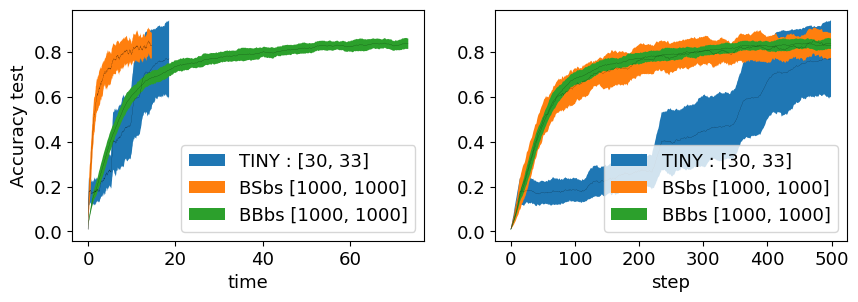

In [37]:
ft = 13
plt.rcParams.update({'font.size': ft})

kernel = torch.cat([torch.ones(num) / num, torch.zeros(num)])[None, None, :]
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

for V, T, label  in zip([V_TINY, V_BSbs, V_BBbs], [T_TINY, T_BSbs, T_BBbs], ['TINY : ' + struc, 'BSbs [1000, 1000]', 'BBbs [1000, 1000]']) :
    V_smooth, T_smooth, V_smooth_std, T_smooth_std = mean_std(V, T)
    #if label == 'BBbs' :
    ax[1].fill_between(np.arange(V_smooth.shape[0]), V_smooth - V_smooth_std, V_smooth + V_smooth_std, label = label)
    ax[1].plot(V_smooth, '-', linewidth=.1, color = 'black')
    
    ax[0].fill_between(T_smooth, V_smooth - V_smooth_std, V_smooth + V_smooth_std, label = label)
    ax[0].plot(T_smooth, V_smooth, linewidth=0.1, color = 'black')
    
ax[0].set_xlabel('time', fontsize = ft)
ax[1].set_xlabel('step', fontsize = ft)

ax[0].set_ylabel('Accuracy test', fontsize = ft)
ax[0].legend()
ax[1].legend()
plt.savefig('figures/TINY_vs_Big.png', bbox_inches = 'tight')


plt.show()

In [34]:
#T